# 0. Data Preparation



## 0.1. Download Data

In [1]:
!pip install -q kaggle

In [2]:
import os


os.environ['KAGGLE_USERNAME'] = '__USERNAME__'
os.environ['KAGGLE_KEY'] = '__KEY__'

In [3]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 96% 382M/398M [00:03<00:00, 115MB/s]
100% 398M/398M [00:03<00:00, 119MB/s]


In [4]:
!unzip -q face-mask-detection.zip

## 0.2. Preprocess Target Data<br>
* convert `xml` to `json`<br>
* generate box and label<br>
* define data preprocessing `class`

In [5]:
!pip install -q xmltodict

In [26]:
import re
import json
import xmltodict
from glob import glob


l_annot_xml = glob('annotations/*.xml')

for annot in l_annot_xml:
  # read xml as string
  with open(annot, 'r') as f:
    s_xml = f.read()
    f.close()

  # convert xml to json
  s_json = json.dumps(xmltodict.parse(s_xml), indent=4)

  # set file name
  file_nm = re.sub('xml', 'json', annot)

  # save json file
  with open(file_nm, 'w') as f:
    f.write(s_json)
    f.close()

l_annot = sorted(glob('annotations/*.json'))
print(len(l_annot))

853


In [27]:
from pprint import pprint


with open(l_annot[0], 'r') as f:
  json_sample = json.load(f)
  f.close()

pprint(json_sample, indent=2)

{ 'annotation': { 'filename': 'maksssksksss0.png',
                  'folder': 'images',
                  'object': [ { 'bndbox': { 'xmax': '109',
                                            'xmin': '79',
                                            'ymax': '142',
                                            'ymin': '105'},
                                'difficult': '0',
                                'name': 'without_mask',
                                'occluded': '0',
                                'pose': 'Unspecified',
                                'truncated': '0'},
                              { 'bndbox': { 'xmax': '226',
                                            'xmin': '185',
                                            'ymax': '144',
                                            'ymin': '100'},
                                'difficult': '0',
                                'name': 'with_mask',
                                'occluded': '0',
                         

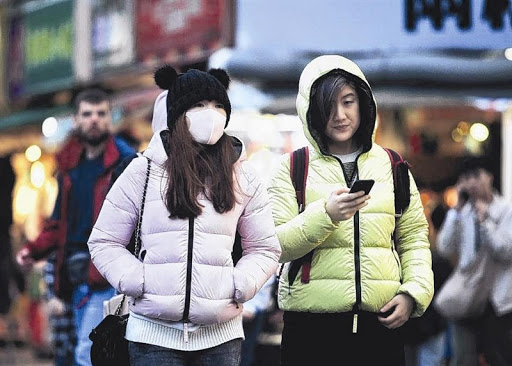

In [28]:
import cv2
from google.colab.patches import cv2_imshow


l_img = sorted(glob('images/*.png'))
img_sample = cv2.imread(l_img[0], cv2.IMREAD_COLOR)
cv2_imshow(img_sample)

In [58]:
def generate_box(obj):
    # get box coordinates
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
  # get label
  if obj.find('name').text == 'with_mask':
    return 2

  elif obj.find('name').text == 'mask_weared_incorrect':
    return 3

  return 1

In [71]:
import torch
from bs4 import BeautifulSoup


def generate_target(img_idx, file_dir):
  with open(file_dir) as f:
    data = f.read()
    f.close()

  soup = BeautifulSoup(data, 'xml')
  objects = soup.find_all('object')

  numOfobj = len(objects)

  boxes = []
  labels = []

  for obj in objects:
    boxes.append(generate_box(obj))
    labels.append(generate_label(obj))

  boxes = torch.as_tensor(boxes, dtype=torch.float32)
  labels = torch.as_tensor(labels, dtype=torch.int64)
  img_idx = torch.tensor([img_idx])

  target = dict({})
  target['boxes'] = boxes
  target['labels'] = labels
  target['img_idx'] = img_idx

  return target

In [72]:
class MaskDataset(object):
  def __init__(self, transforms):
    self.transforms = transforms
    self.imgs = sorted(glob('images/*.png'))

  def __getitem__(self, idx):
    file_image = f'maksssksksss{idx}.png'
    file_label = f'maksssksksss{idx}.xml'
    img_path = os.path.join('images/', file_image)
    label_path = os.path.join('annotations/', file_label)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    target = generate_target(idx, label_path)

    if self.transforms is not None:
      img = self.transforms(img)
    
    return img, target

  def __len__(self):
    return len(self.imgs)

In [73]:
import torchvision
from torchvision import transforms, datasets, models


data_transform = transforms.Compose([transforms.ToTensor(),])

def collate_fn(batch):
  return tuple(zip(*batch))
  
dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

In [67]:
torch.cuda.is_available()

True

## 0.3. Split Data<br>
* train:test = 8:2<br>
* `random_state`: 100

In [ ]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(l_annot, test_size=0.2, random_state=100)
train, valid = train_test_split(train, test_size=0.25, random_state=100)
train.extend(valid)

print(len(train), len(test))

# 1. Modeling

## 1.1. Define Model Object

In [74]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1)

  return model

In [16]:
model = get_model_instance_segmentation(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [75]:
device = torch.device('cuda')

for imgs, annotations in data_loader:
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  break

## 1.2. Train Model

In [76]:
num_epochs = 50
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005
                            )

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses

In [115]:
for imgs, annotations in data_loader:
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  break

In [78]:
model.eval()
preds = model(imgs)

In [80]:
preds[0]

{'boxes': tensor([[184.0667, 101.3407, 224.2171, 143.6582],
         [326.0342,  89.9359, 360.1022, 140.7233],
         [ 79.4839, 105.5895, 109.1856, 140.3521]], device='cuda:0',
        grad_fn=<StackBackward>),
 'labels': tensor([2, 1, 1], device='cuda:0'),
 'scores': tensor([0.9988, 0.9956, 0.9939], device='cuda:0', grad_fn=<IndexBackward>)}

In [96]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [246]:
d_label = {
    1: 'without_mask',
    2: 'with_mask',
    3: 'mask_weared_incorrect'
}

def plot_image(img_tensor, annotation):
    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    img = img_tensor.cpu().data

    # display the image
    ax.imshow(img.permute(1, 2, 0))
    
    numOfobj = len(annotation['boxes'])
    for i in range(numOfobj):
      box = annotation['boxes'][i]
      label = d_label[annotation['labels'][i].data.item()]
      score = round(annotation['scores'][i].data.item(), 5)
      text = f'{label}\n{score}'

      xmin, ymin, xmax, ymax = box

      # create a Rectangle patch
      rect = patches.Rectangle((xmin, ymin),
                               (xmax - xmin),
                               (ymax - ymin),
                               linewidth=3,
                               edgecolor='r',
                               facecolor='none')

      # add the patch to the Axes
      ax.add_patch(rect)
      plt.text(xmin, ymin - 7.5, text, backgroundcolor='r', color='w')

    ax.set_xlabel(f'total {numOfobj} people', fontsize=12)
    plt.show()

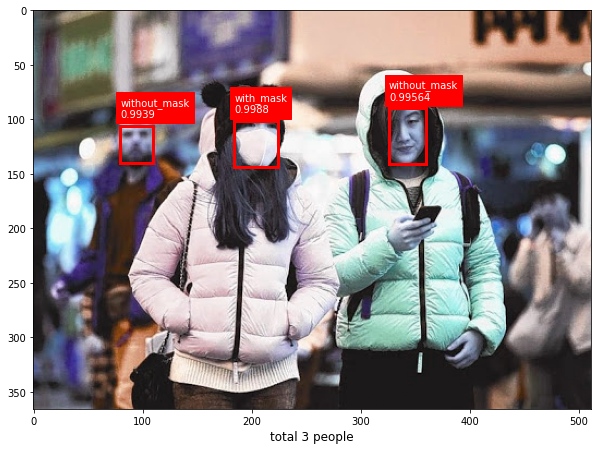

In [247]:
plot_image(imgs[0], preds[0])